In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PROCESSED = Path("../data/processed")

X = pd.read_parquet(DATA_PROCESSED / "X_encoded.parquet")
y = pd.read_parquet(DATA_PROCESSED / "y_target.parquet")["target"]

print("✅ Données chargées :", X.shape, y.shape)


✅ Données chargées : (1470, 39) (1470,)


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Répartition :")
print("Train :", X_train.shape, "| Test :", X_test.shape)
print(y_train.value_counts(normalize=True))


✅ Répartition :
Train : (1176, 39) | Test : (294, 39)
target
0    0.838435
1    0.161565
Name: proportion, dtype: float64


In [3]:
# Concatène X et y pour échantillonnage
train_data = pd.concat([X_train, y_train], axis=1)

# Sépare les deux classes
majority = train_data[train_data.target == 0]
minority = train_data[train_data.target == 1]

# Sur-échantillonnage de la classe minoritaire
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

train_balanced = pd.concat([majority, minority_upsampled])
X_train_bal = train_balanced.drop("target", axis=1)
y_train_bal = train_balanced["target"]

print("✅ Après équilibrage :")
print(y_train_bal.value_counts())


✅ Après équilibrage :
target
0    986
1    986
Name: count, dtype: int64


In [4]:
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_log = cross_validate(
    log_reg, X_train_bal, y_train_bal,
    cv=cv, scoring=["accuracy", "precision", "recall"]
)

print("🔹 Régression Logistique - Cross Validation")
for metric in scores_log:
    if "test" in metric:
        print(f"{metric}: {scores_log[metric].mean():.3f} ± {scores_log[metric].std():.3f}")


🔹 Régression Logistique - Cross Validation
test_accuracy: 0.778 ± 0.009
test_precision: 0.771 ± 0.014
test_recall: 0.792 ± 0.015


In [5]:
rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=None, 
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

scores_rf = cross_validate(
    rf, X_train, y_train,
    cv=cv, scoring=["accuracy", "precision", "recall"]
)

print("🔹 Random Forest - Cross Validation")
for metric in scores_rf:
    if "test" in metric:
        print(f"{metric}: {scores_rf[metric].mean():.3f} ± {scores_rf[metric].std():.3f}")


🔹 Random Forest - Cross Validation
test_accuracy: 0.861 ± 0.009
test_precision: 0.844 ± 0.151
test_recall: 0.184 ± 0.058


🔹 Logistic Regression (test set)
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       247
           1       0.38      0.70      0.49        47

    accuracy                           0.77       294
   macro avg       0.66      0.74      0.67       294
weighted avg       0.84      0.77      0.79       294

🔹 Random Forest (test set)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.45      0.11      0.17        47

    accuracy                           0.84       294
   macro avg       0.65      0.54      0.54       294
weighted avg       0.79      0.84      0.79       294



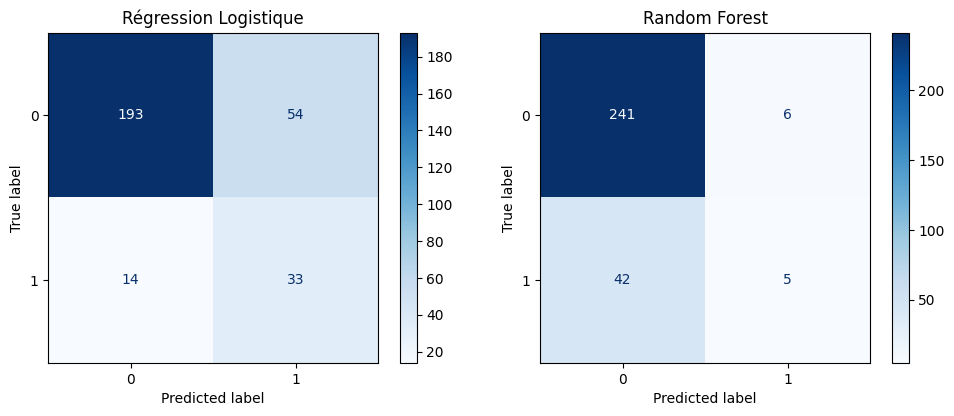

In [6]:
# Entraînement final sur tout le train équilibré
log_reg.fit(X_train_bal, y_train_bal)
rf.fit(X_train, y_train)

# Prédictions sur le test initial (non équilibré)
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)

print("🔹 Logistic Regression (test set)")
print(classification_report(y_test, y_pred_log))

print("🔹 Random Forest (test set)")
print(classification_report(y_test, y_pred_rf))

# Matrices de confusion
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap="Blues", ax=ax[0])
ax[0].set_title("Régression Logistique")
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues", ax=ax[1])
ax[1].set_title("Random Forest")
plt.tight_layout()
plt.show()


,Accuracy,Precision,Recall
Modèle,,,
Logistique,0.778,0.771,0.792
RandomForest,0.861,0.844,0.184


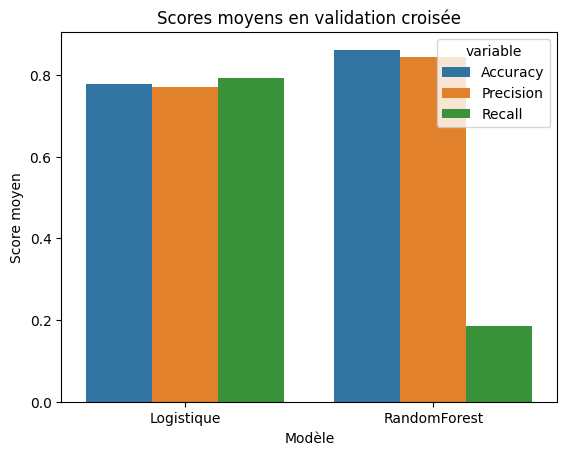

In [7]:
summary = pd.DataFrame({
    "Modèle": ["Logistique", "RandomForest"],
    "Accuracy": [
        scores_log["test_accuracy"].mean(),
        scores_rf["test_accuracy"].mean()
    ],
    "Precision": [
        scores_log["test_precision"].mean(),
        scores_rf["test_precision"].mean()
    ],
    "Recall": [
        scores_log["test_recall"].mean(),
        scores_rf["test_recall"].mean()
    ]
})
summary.set_index("Modèle", inplace=True)
display(summary.round(3))

sns.barplot(data=summary.reset_index().melt(id_vars="Modèle"), x="Modèle", y="value", hue="variable")
plt.title("Scores moyens en validation croisée")
plt.ylabel("Score moyen")
plt.show()


In [8]:
X_train_bal.to_parquet("../data/processed/X_train_bal.parquet", index=False)
y_train_bal.to_frame("target").to_parquet("../data/processed/y_train_bal.parquet", index=False)
X_test.to_parquet("../data/processed/X_test.parquet", index=False)
y_test.to_frame("target").to_parquet("../data/processed/y_test.parquet", index=False)